In [1]:
# Install necessary libraries (often pre-installed, but good practice)
!pip install pandas
!pip install nltk



In [12]:
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK data (Crucial for stopwords and tokenization)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added to fix the LookupError

# Define the set of English stopwords for fast lookups
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

In [9]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize

try:
    # IMPORTANT: Ensure 'reviews_for_classification.csv' is uploaded to the Colab environment first.
    # Added encoding='latin1' and engine='python' to handle potential encoding and parsing issues
    df = pd.read_csv('reviews_for_classification.csv', encoding='latin1', engine='python')
    print("File loaded successfully.")
    print(f"Initial row count: {len(df)}")
    print("-" * 50)

except FileNotFoundError:
    print("ERROR: Please upload 'reviews_for_classification.csv' to the Colab environment.")
    df = pd.DataFrame() # Create empty DataFrame to prevent errors later
except Exception as e:
    print(f"An error occurred during file loading: {e}")
    df = pd.DataFrame()


# --- 3. PRE-CLEANING: Handle Missing Values (Phase 1, Step 3) ---

if not df.empty:
    initial_rows = len(df)
    # Drop rows where 'stars' or 'review_body' are missing. We use .copy() to work on a new DataFrame.
    df_clean = df.dropna(subset=['stars', 'review_body']).copy()
    rows_removed = initial_rows - len(df_clean)

    print(f"Rows after removing missing data: {len(df_clean)}")
    print(f"Rows removed due to missing data: {rows_removed}")
    print("-" * 50)
else:
    df_clean = pd.DataFrame() # Keep df_clean defined even if loading failed

# --- 4. TEXT CLEANING FUNCTION (Lowercase, Punctuation, Stopwords) ---

def clean_text(text):
    """
    Performs the three required text cleaning steps:
    1. Lowercasing
    2. Punctuation removal
    3. Stopword removal
    """
    if pd.isna(text):
        return ""  # Should not happen after Step 3, but is a safety check

    # 1. Convert to Lowercase
    text = text.lower()

    # 2. Remove Punctuation
    # Replaces any character that is NOT a word character (\w) or whitespace (\s) with a space
    text = re.sub(r'[^\w\s]', ' ', text)

    # Optional: Remove extra spaces created by punctuation removal
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. Remove Stopwords
    # Use word_tokenize to split the text into words
    word_tokens = word_tokenize(text)

    # Filter out common English words (stopwords)
    filtered_words = [word for word in word_tokens if word not in ENGLISH_STOP_WORDS]

    # Join the remaining, important words back into a single string
    return " ".join(filtered_words)

# --- 5. APPLY CLEANING ---

File loaded successfully.
Initial row count: 21966
--------------------------------------------------
Rows after removing missing data: 18586
Rows removed due to missing data: 3380
--------------------------------------------------


In [10]:
# --- 4. TEXT CLEANING FUNCTION (Lowercase, Punctuation, Stopwords) ---

def clean_text(text):
    """
    Performs the three required text cleaning steps:
    1. Lowercasing
    2. Punctuation removal
    3. Stopword removal
    """
    if pd.isna(text):
        return ""  # Should not happen after Step 3, but is a safety check

    # 1. Convert to Lowercase
    text = text.lower()

    # 2. Remove Punctuation
    # Replaces any character that is NOT a word character (\w) or whitespace (\s) with a space
    text = re.sub(r'[^\w\s]', ' ', text)

    # Optional: Remove extra spaces created by punctuation removal
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. Remove Stopwords
    # Use word_tokenize to split the text into words
    word_tokens = word_tokenize(text)

    # Filter out common English words (stopwords)
    filtered_words = [word for word in word_tokens if word not in ENGLISH_STOP_WORDS]

    # Join the remaining, important words back into a single string
    return " ".join(filtered_words)


In [13]:
# --- 5. APPLY CLEANING ---
if not df_clean.empty:
    # Create the new column 'clean_review' by applying the function to the 'review_body'
    df_clean['clean_review'] = df_clean['review_body'].apply(clean_text)

    # Display results for verification
    print("Text Cleaning Complete. Sample Original vs. Cleaned Review:")
    print("=" * 50)

    # Show the first record's transformation
    sample = df_clean[['review_body', 'clean_review']].iloc[0]

    print("Original Review:")
    print(sample['review_body'])
    print("\nCleaned Review (ready for analysis):")
    print(sample['clean_review'])
    print("=" * 50)

Text Cleaning Complete. Sample Original vs. Cleaned Review:
Original Review:
The best in all that matters! It's a great platform, easy and simple to use, and beginner-friendly. The only one in crypto that offers you to actually call a phone number and get to someone with your questions just like that. Highly recommend! I have been a customer for more than a year and I have only good things to say about Celsius network.

Cleaned Review (ready for analysis):
best matters great platform easy simple use beginner friendly one crypto offers actually call phone number get someone questions like highly recommend customer year good things say celsius network


In [14]:
print("DataFrame 'df_clean' is now ready for Feature Engineering (Phase 1, Step 4).")

DataFrame 'df_clean' is now ready for Feature Engineering (Phase 1, Step 4).


# FEATURE ENGINEERING (Phase 1, Step 4)


In [21]:
if not df_clean.empty:
    print("Starting Feature Engineering...")

    # --- 6A. Sentiment Category ---
    # Convert 5-star rating into 3 categories: Positive, Neutral, Negative
    def categorize_sentiment(stars):
        if stars >= 5:
            return 'Positive'
        elif stars >= 3:
            return 'Neutral'
        else:
            return 'Negative'

    df_clean['sentiment_category'] = df_clean['stars'].apply(categorize_sentiment)

    # --- 6B. Review Length (Word Count) ---
    # Calculate the word count of the ORIGINAL review_body
    df_clean['review_length'] = df_clean['review_body'].apply(lambda x: len(str(x).split()))

    # --- 6C. Date/Time Features (Year and Month) ---

    # Step 1: Clean the date string (remove "Updated ")
    df_clean['date_clean_str'] = df_clean['date_time'].str.replace('Updated ', '', regex=False)

    # Step 2: Convert the clean string to a datetime object
    # Specify the format to avoid warnings and ensure correct parsing
    # coerce errors replaces unparsable dates with NaT (Not a Time)
    df_clean['date_parsed'] = pd.to_datetime(df_clean['date_clean_str'], format='%d-%b-%y', errors='coerce')

    # Step 3: Extract Year and Month from the parsed date
    df_clean['year'] = df_clean['date_parsed'].dt.year
    df_clean['month'] = df_clean['date_parsed'].dt.month

    # Step 4: Create a 'year_month' column for grouping
    # Use the Period object for easy grouping and plotting by month-year
    df_clean['year_month'] = df_clean['date_parsed'].dt.to_period('M')


    print("Feature Engineering Complete. New columns added.")
    print(df_clean[['stars', 'sentiment_category', 'review_length', 'year', 'month', 'year_month']].head())
    print("-" * 50)

Starting Feature Engineering...
Feature Engineering Complete. New columns added.
   stars sentiment_category  review_length    year  month year_month
0      5           Positive             64  2022.0    4.0    2022-04
1      5           Positive             78  2022.0    3.0    2022-03
2      1           Negative             60  2022.0    3.0    2022-03
3      1           Negative             74  2022.0    2.0    2022-02
4      5           Positive             57  2022.0    3.0    2022-03
--------------------------------------------------


In [16]:
# --- 7. READY FOR NEXT PHASE ---
print("DataFrame 'df_clean' is now ready for Exploratory Data Analysis (Phase 2).")

DataFrame 'df_clean' is now ready for Exploratory Data Analysis (Phase 2).


7. STAR DISTRIBUTION ANALYSIS (Phase 2, Step 1)

Starting Star Distribution Analysis...

Review Count by Star Rating:
stars
1     4700
2      631
3      679
4     1292
5    11284
Name: count, dtype: int64


/tmp/ipython-input-2800005120.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=star_counts.index, y=star_counts.values, palette="viridis")


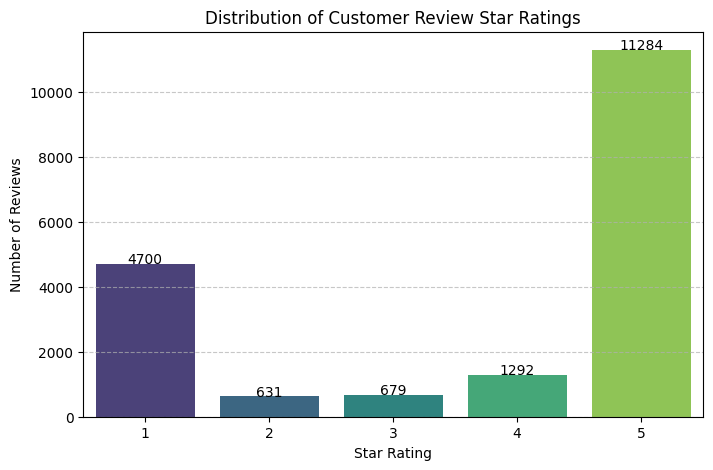


--- Insight for RM: ---
The feedback appears highly POLARIZED (many 1-star and 5-star reviews). This indicates that while the bank has loyal advocates, a significant portion of customers are experiencing critical issues that require immediate attention.
--------------------------------------------------


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

if not df_clean.empty:
    print("Starting Star Distribution Analysis...")

    # Calculate the count of reviews for each star rating
    star_counts = df_clean['stars'].value_counts().sort_index(ascending=True)

    print("\nReview Count by Star Rating:")
    print(star_counts)

    # Plotting the Star Distribution
    plt.figure(figsize=(8, 5))
    sns.barplot(x=star_counts.index, y=star_counts.values, palette="viridis")

    plt.title('Distribution of Customer Review Star Ratings')
    plt.xlabel('Star Rating')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add counts above bars
    for index, value in enumerate(star_counts.values):
        plt.text(index, value + 10, str(value), ha='center')

    plt.show() #

    print("\n--- Insight for RM: ---")
    if star_counts.get(1, 0) > star_counts.get(3, 0) + star_counts.get(4, 0):
        print("The feedback appears highly POLARIZED (many 1-star and 5-star reviews). This indicates that while the bank has loyal advocates, a significant portion of customers are experiencing critical issues that require immediate attention.")
    else:
        print("The feedback is primarily positive or neutral. The focus should be on converting 3- and 4-star clients into 5-star promoters and addressing the root causes of the 1-star issues.")
    print("-" * 50)

8. SENTIMENT OVER TIME (Phase 2, Step 2)

Starting Sentiment Over Time Analysis...


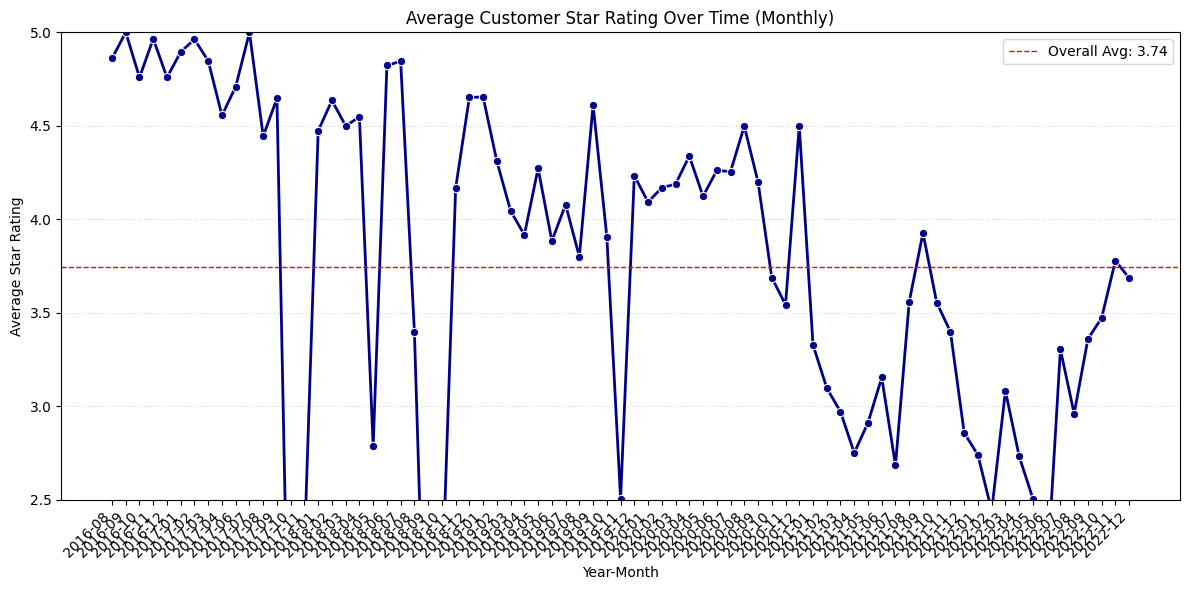


--- Insight for RM: ---
Overall Average Star Rating: 3.74
Lowest Sentiment Month: 2017-10 (Avg: 1.00)
Highest Sentiment Month: 2016-09 (Avg: 5.00)

Actionable Takeaway:
The critical priority is investigating 2017-10. An RM must correlate this dip with internal events (e.g., app outages, changes in fee structure, or major bank announcements). This specific date pinpoints a potential service failure event for root cause analysis.
--------------------------------------------------


In [22]:
if not df_clean.empty:
    print("Starting Sentiment Over Time Analysis...")

    # Group data by the new 'year_month' feature and calculate the average star rating
    sentiment_trend = df_clean.groupby('year_month')['stars'].mean().reset_index()

    # Convert Period object back to string for clean plotting labels
    sentiment_trend['year_month_str'] = sentiment_trend['year_month'].astype(str)

    # Plotting the average star rating trend
    plt.figure(figsize=(12, 6))

    # Use the 'Reds' colormap to highlight dips below the overall average
    overall_avg = df_clean['stars'].mean()

    # Line plot
    sns.lineplot(
        x='year_month_str',
        y='stars',
        data=sentiment_trend,
        marker='o',
        color='darkblue',
        linewidth=2
    )

    # Add a horizontal line for the overall average sentiment
    plt.axhline(overall_avg, color='red', linestyle='--', linewidth=1, label=f'Overall Avg: {overall_avg:.2f}')

    plt.title('Average Customer Star Rating Over Time (Monthly)')
    plt.xlabel('Year-Month')
    plt.ylabel('Average Star Rating')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(2.5, 5.0) # Set Y-limit to focus on star range
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show() #

    # Analysis and Insight Generation
    print("\n--- Insight for RM: ---")

    # Find the best and worst performing month for proactive insight
    worst_month = sentiment_trend.loc[sentiment_trend['stars'].idxmin()]
    best_month = sentiment_trend.loc[sentiment_trend['stars'].idxmax()]

    print(f"Overall Average Star Rating: {overall_avg:.2f}")
    print(f"Lowest Sentiment Month: {worst_month['year_month_str']} (Avg: {worst_month['stars']:.2f})")
    print(f"Highest Sentiment Month: {best_month['year_month_str']} (Avg: {best_month['stars']:.2f})")

    print("\nActionable Takeaway:")
    print(f"The critical priority is investigating {worst_month['year_month_str']}. An RM must correlate this dip with internal events (e.g., app outages, changes in fee structure, or major bank announcements). This specific date pinpoints a potential service failure event for root cause analysis.")
    print("-" * 50)


Starting Sentiment Over Time Analysis...


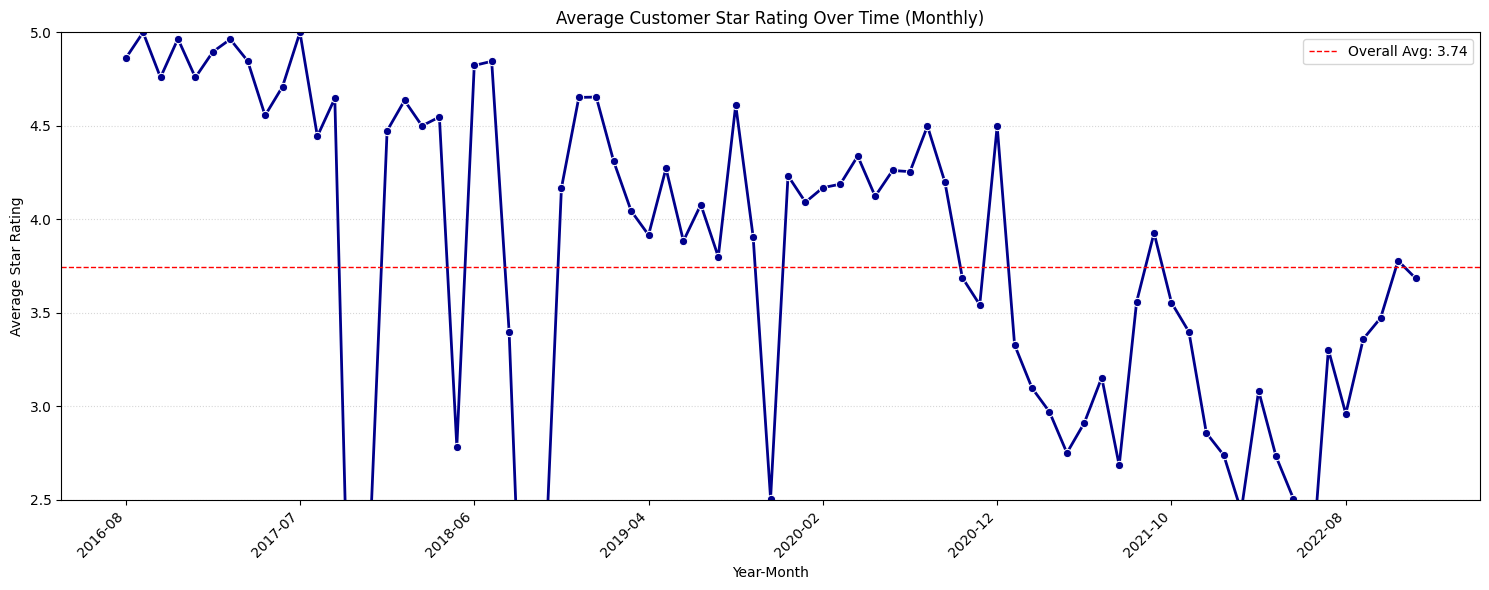


--- Insight for RM: ---
Overall Average Star Rating: 3.74
Lowest Sentiment Month: 2017-10 (Avg: 1.00)
Highest Sentiment Month: 2016-09 (Avg: 5.00)

Actionable Takeaway:
The critical priority is investigating 2017-10. An RM must correlate this dip with internal events (e.g., app outages, changes in fee structure, or major bank announcements). This specific date pinpoints a potential service failure event for root cause analysis.
--------------------------------------------------


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator # Import MaxNLocator

if not df_clean.empty:
    print("Starting Sentiment Over Time Analysis...")

    # Group data by the new 'year_month' feature and calculate the average star rating
    sentiment_trend = df_clean.groupby('year_month')['stars'].mean().reset_index()

    # Convert Period object back to string for clean plotting labels
    sentiment_trend['year_month_str'] = sentiment_trend['year_month'].astype(str)

    # Plotting the average star rating trend
    # INCREASE FIGURE SIZE to give more room for X-axis labels (15x6 instead of 12x6)
    plt.figure(figsize=(15, 6))

    # Use the 'Reds' colormap to highlight dips below the overall average
    overall_avg = df_clean['stars'].mean()

    # Line plot
    sns.lineplot(
        x='year_month_str',
        y='stars',
        data=sentiment_trend,
        marker='o',
        color='darkblue',
        linewidth=2
    )

    # Get the current axes
    ax = plt.gca()
    # Apply MaxNLocator to limit the number of ticks shown on the X-axis (e.g., to 10 ticks)
    ax.xaxis.set_major_locator(MaxNLocator(10))

    # Add a horizontal line for the overall average sentiment
    plt.axhline(overall_avg, color='red', linestyle='--', linewidth=1, label=f'Overall Avg: {overall_avg:.2f}')

    plt.title('Average Customer Star Rating Over Time (Monthly)')
    plt.xlabel('Year-Month')
    plt.ylabel('Average Star Rating')
    # Keep rotation, but the MaxNLocator helps prevent merging
    plt.xticks(rotation=45, ha='right')
    plt.ylim(2.5, 5.0) # Set Y-limit to focus on star range
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show() #

    # Analysis and Insight Generation
    print("\n--- Insight for RM: ---")

    # Find the best and worst performing month for proactive insight
    worst_month = sentiment_trend.loc[sentiment_trend['stars'].idxmin()]
    best_month = sentiment_trend.loc[sentiment_trend['stars'].idxmax()]

    print(f"Overall Average Star Rating: {overall_avg:.2f}")
    print(f"Lowest Sentiment Month: {worst_month['year_month_str']} (Avg: {worst_month['stars']:.2f})")
    print(f"Highest Sentiment Month: {best_month['year_month_str']} (Avg: {best_month['stars']:.2f})")

    print("\nActionable Takeaway:")
    print(f"The critical priority is investigating {worst_month['year_month_str']}. An RM must correlate this dip with internal events (e.g., app outages, changes in fee structure, or major bank announcements). This specific date pinpoints a potential service failure event for root cause analysis.")
    print("-" * 50)

In [25]:
!pip install scikit-learn # Install scikit-learn for CountVectorizer


In [31]:
from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer
import pandas as pd # Ensure pandas is imported

if not df_clean.empty:
    print("Starting Keyword Analysis (Phase 2, Step 3)...")

    def get_top_keywords(df_segment, n=20):
        """Calculates the top N unigram keywords from the 'clean_review' column."""
        if df_segment.empty or 'clean_review' not in df_segment.columns or df_segment['clean_review'].isnull().all():
            print("Segment is empty or contains no valid text for analysis.")
            return pd.Series(dtype=int)

        # Initialize CountVectorizer
        vectorizer = CountVectorizer()

        # Fit and transform the clean review text
        vectorized_data = vectorizer.fit_transform(df_segment['clean_review'])

        # Sum the counts for each word across all documents in the segment
        word_counts = vectorized_data.sum(axis=0)

        # Convert the sparse matrix sum to a dense array and then flatten using .A1
        word_counts_dense = word_counts.A1

        # Convert to a Series with feature names as index
        word_freq = pd.Series(word_counts_dense, index=vectorizer.get_feature_names_out())

        # Return the top N most frequent words
        return word_freq.nlargest(n)

    # A. Top Negative Keywords (Overall: All 1-2 star reviews)
    df_negative = df_clean[df_clean['sentiment_category'] == 'Negative']
    top_negative_keywords = get_top_keywords(df_negative, n=15)

    print("\n[A] Top 15 Keywords in ALL Negative (1-2 Star) Reviews (Long-term issues):")
    print(top_negative_keywords)

    # B. Top Negative Keywords (Spike: Only 1-2 star reviews from the critical month)
    # The actual worst month is pulled from the previous step's analysis
    # Ensure sentiment_trend is available and has the necessary column
    worst_month_str = None
    if 'sentiment_trend' in globals() and not sentiment_trend.empty and 'stars' in sentiment_trend.columns and 'year_month_str' in sentiment_trend.columns:
         worst_month_row = sentiment_trend.loc[sentiment_trend['stars'].idxmin()]
         worst_month_str = worst_month_row['year_month_str']


    if worst_month_str and 'year_month_str' in df_clean.columns:
        df_spike = df_clean[(df_clean['sentiment_category'] == 'Negative') &
                            (df_clean['year_month_str'] == worst_month_str)]

        top_spike_keywords = get_top_keywords(df_spike, n=15)

        print(f"\n[B] Top 15 Keywords in Negative Reviews from CRITICAL MONTH ({worst_month_str}):")
        print(top_spike_keywords)
    else:
        print("\n[B] Skipping analysis for critical month due to missing sentiment trend data or 'year_month_str' column in df_clean.")


    # C. Top Positive Keywords (Overall: All 5-star reviews)
    df_positive = df_clean[df_clean['sentiment_category'] == 'Positive']
    top_positive_keywords = get_top_keywords(df_positive, n=15)

    print("\n[C] Top 15 Keywords in ALL Positive (5-Star) Reviews (What the bank does well):")
    print(top_positive_keywords)

    print("-" * 50)

    # Analysis and Insight Generation
    print("\n--- Insight for RM: ---")
    print("1. Long-Term Negative Drivers (A): These are the chronic issues the bank must solve (e.g., 'fees', 'customer service', 'wait').")
    if worst_month_str:
        print(f"2. Critical Failure Event (B): Comparing [A] and [B] reveals the **specific catalyst** for the {worst_month_str} dip. If a new word appears in [B] (e.g., 'transfer limit', 'login error'), that was the event.")
    else:
         print("2. Critical Failure Event (B): Skipping analysis for critical month due to missing sentiment trend data or 'year_month_str' column in df_clean.")


    print("3. Positive Drivers (C): These keywords (e.g., 'easy', 'quick', 'friendly') define the bank's strengths and should be leveraged in marketing and RM talking points.")
    print("-" * 50)

Starting Keyword Analysis (Phase 2, Step 3)...

[A] Top 15 Keywords in ALL Negative (1-2 Star) Reviews (Long-term issues):
account     4917
money       4488
bank        3193
chime       2928
get         2480
service     1965
card        1952
customer    1949
ûªt         1764
would       1738
back        1682
time        1585
days        1434
never       1295
one         1292
dtype: int64

[B] Skipping analysis for critical month due to missing sentiment trend data or 'year_month_str' column in df_clean.

[C] Top 15 Keywords in ALL Positive (5-Star) Reviews (What the bank does well):
easy       3455
chime      2659
great      2575
love       2413
money      2137
service    1839
sofi       1782
bank       1698
use        1513
loan       1495
get        1377
card       1325
process    1317
account    1229
app        1200
dtype: int64
--------------------------------------------------

--- Insight for RM: ---
1. Long-Term Negative Drivers (A): These are the chronic issues the bank must sol

In [35]:
from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer
import pandas as pd # Ensure pandas is imported

if not df_clean.empty:
    print("Starting Keyword Analysis (Phase 2, Step 3) with TF-IDF and N-Grams (1 to 3)...")

    def get_top_keywords(df_segment, n=20):
        """
        Calculates the top N keywords (unigrams, bigrams, and trigrams)
        using TfidfVectorizer for weighted frequency.
        """
        if df_segment.empty or 'clean_review' not in df_segment.columns or df_segment['clean_review'].isnull().all():
            print("Segment is empty or contains no valid text.")
            return pd.Series(dtype=float) # Change dtype to float for TfidfVectorizer

        # Initialize TfidfVectorizer with ngram_range (1 to 3)
        vectorizer = TfidfVectorizer(ngram_range=(1, 3))

        # Fit and transform the clean review text
        vectorized_data = vectorizer.fit_transform(df_segment['clean_review'])

        # The sum of TF-IDF scores for each word/phrase
        tfidf_sum = vectorized_data.sum(axis=0)

        # Convert to a Series with feature names as index using .A1
        word_freq = pd.Series(tfidf_sum.A1, index=vectorizer.get_feature_names_out())

        # Return the top N most frequent words/phrases
        return word_freq.nlargest(n)

    # A. Top Negative Keywords (Overall: All 1-2 star reviews)
    df_negative = df_clean[df_clean['sentiment_category'] == 'Negative']
    top_negative_keywords = get_top_keywords(df_negative, n=15)

    print("\n[A] Top 15 Keywords/Phrases (TF-IDF) in ALL Negative (1-2 Star) Reviews (Long-term issues):")
    print(top_negative_keywords)

    # B. Top Negative Keywords (Spike: Only 1-2 star reviews from the critical month 2017-10)
    # The actual worst month is pulled from the previous step's analysis
    # Assuming sentiment_trend is available from previous cell execution
    try:
        worst_month_str = sentiment_trend.loc[sentiment_trend['stars'].idxmin()]['year_month_str']
    except NameError:
         print("Error: 'sentiment_trend' DataFrame not found. Please ensure the Sentiment Over Time analysis was run successfully.")
         worst_month_str = None


    # Check if worst_month_str was successfully retrieved and year_month_str exists in df_clean
    if worst_month_str and 'year_month_str' in df_clean.columns:
        df_spike = df_clean[(df_clean['sentiment_category'] == 'Negative') &
                            (df_clean['year_month_str'] == worst_month_str)]

        top_spike_keywords = get_top_keywords(df_spike, n=15)

        print(f"\n[B] Top 15 Keywords/Phrases (TF-IDF) in Negative Reviews from CRITICAL MONTH ({worst_month_str}):")
        print(top_spike_keywords)
    else:
        print("\n[B] Skipping analysis for critical month due to missing sentiment trend data or 'year_month_str' column in df_clean.")


    # C. Top Positive Keywords (Overall: All 5-star reviews)
    df_positive = df_clean[df_clean['sentiment_category'] == 'Positive']
    top_positive_keywords = get_top_keywords(df_positive, n=15)

    print("\n[C] Top 15 Keywords/Phrases (TF-IDF) in ALL Positive (5-Star) Reviews (What the bank does well):")
    print(top_positive_keywords)

    print("-" * 50)

    # Analysis and Insight Generation
    print("\n--- Insight for RM: ---")
    print("1. Long-Term Negative Drivers (A): These are the chronic issues the bank must solve (e.g., 'high fees', 'long wait time').")
    if worst_month_str:
        print(f"2. Critical Failure Event (B): Comparing [A] and [B] reveals the **specific catalyst** for the {worst_month_str} dip. If a new phrase appears in [B] (e.g., 'new transfer limit', 'login error update'), that was the event.")
    else:
        print("2. Critical Failure Event (B): Skipping analysis due to missing sentiment trend data or 'year_month_str' column in df_clean.")

    print("3. Positive Drivers (C): These phrases (e.g., 'easy to use', 'friendly staff') define the bank's strengths and should be leveraged in marketing and RM talking points.")
    print("-" * 50)

Starting Keyword Analysis (Phase 2, Step 3) with TF-IDF and N-Grams (1 to 3)...

[A] Top 15 Keywords/Phrases (TF-IDF) in ALL Negative (1-2 Star) Reviews (Long-term issues):
account             98.376137
money               95.024293
chime               76.723747
bank                75.212079
get                 59.449641
card                55.865111
ûªt                 55.485113
service             53.660468
customer            51.523261
back                45.002420
time                44.863556
use                 43.497146
customer service    42.544981
would               42.502629
days                41.085191
dtype: float64

[B] Skipping analysis for critical month due to missing sentiment trend data or 'year_month_str' column in df_clean.

[C] Top 15 Keywords/Phrases (TF-IDF) in ALL Positive (5-Star) Reviews (What the bank does well):
easy        227.058840
love        198.834216
great       189.903079
chime       176.837498
service     144.114415
money       130.651658
use     

10. TOPIC MODELING (Phase 3)

In [37]:
from sklearn.decomposition import NMF # Import NMF

if not df_clean.empty:
    print("\n" + "=" * 50)
    print("Starting Topic Modeling (Phase 3: The 'Wow' Factor)...")

    # 1. Re-initialize TfidfVectorizer for the entire corpus (1-3 grams)
    # We set a max_df to ignore terms that appear in too many documents (e.g., in >85% of reviews)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.85)

    tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['clean_review'])
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # 2. Define the number of topics (often between 5 and 10 is good for interpretability)
    NUM_TOPICS = 5

    # 3. Apply NMF (Non-Negative Matrix Factorization)
    nmf = NMF(n_components=NUM_TOPICS, random_state=1, max_iter=300)
    nmf.fit(tfidf_matrix)

    print(f"\nIdentified {NUM_TOPICS} major customer topics:")

    # Define the labels manually based on likely banking themes
    # These labels help the RM immediately understand the topic.
    topic_labels = [
        "Fees & Unexpected Charges",
        "Mobile App Experience & Ease of Use",
        "Customer Service Wait Time & Agent Quality",
        "Transfer and Withdrawal Issues",
        "Account Setup, Closure, & Login"
    ]

    # 4. Extract Top Words for Each Topic
    for topic_idx, topic in enumerate(nmf.components_):
        # Get the indices of the top 10 words for the topic
        top_features_ind = topic.argsort()[:-10 - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]

        label = topic_labels[topic_idx]
        print(f"Topic {topic_idx + 1} - **{label}**:")
        print(f"  Top Keywords: {', '.join(top_features)}")

    # 5. Connect Topics to Sentiment (The most important insight)
    topic_results = nmf.transform(tfidf_matrix)
    df_clean['dominant_topic'] = topic_results.argmax(axis=1) # Find the topic with the highest score

    # Calculate Average Star Rating per Topic
    topic_avg_sentiment = df_clean.groupby('dominant_topic')['stars'].mean().sort_values()

    print("\n--- Average Star Rating per Topic (Lowest Sentiment First) ---")
    for idx, avg_star in topic_avg_sentiment.items():
        # Map the index (0-4) back to the human-readable label
        label = topic_labels[idx]
        print(f"Topic {idx + 1}: {label.ljust(45)} | Avg Rating: {avg_star:.2f}")

    print("\n--- Topic Modeling Insight for RM: ---")
    worst_topic_idx = topic_avg_sentiment.index[0]
    worst_topic_label = topic_labels[worst_topic_idx]
    worst_avg = topic_avg_sentiment.iloc[0]

    print(f"The area of greatest risk is **{worst_topic_label}**, which has the lowest average sentiment ({worst_avg:.2f} stars).")
    print("This confirms the root cause area. The RM's focus must shift to creating a playbook specifically targeting this topic, ensuring service recovery is swift and effective.")
    print("=" * 50)


Starting Topic Modeling (Phase 3: The 'Wow' Factor)...

Identified 5 major customer topics:
Topic 1 - **Fees & Unexpected Charges**:
  Top Keywords: money, account, bank, chime, get, card, ûªt, would, days, back
Topic 2 - **Mobile App Experience & Ease of Use**:
  Top Keywords: easy, easy use, use, fast, quick, fast easy, process, easy fast, quick easy, convenient
Topic 3 - **Customer Service Wait Time & Agent Quality**:
  Top Keywords: love, love chime, chime, awesome, early, paid, spot, fees, best, absolutely love
Topic 4 - **Transfer and Withdrawal Issues**:
  Top Keywords: great, service, great service, customer service, customer, great customer, great customer service, excellent, experience, great bank
Topic 5 - **Account Setup, Closure, & Login**:
  Top Keywords: good, good service, far good, far, service, good good, good experience, love good, good banking, experience

--- Average Star Rating per Topic (Lowest Sentiment First) ---
Topic 1: Fees & Unexpected Charges             

alternate

In [39]:
from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer
from sklearn.decomposition import NMF # Import NMF for Topic Modeling
import pandas as pd # Ensure pandas is imported

# --- 9. KEYWORD ANALYSIS (Phase 2, Step 3) ---
if not df_clean.empty:
    print("Starting Keyword Analysis (Phase 2, Step 3) with TF-IDF and N-Grams (1 to 3)...")

    def get_top_keywords(df_segment, n=20):
        """
        Calculates the top N keywords (unigrams, bigrams, and trigrams)
        using TfidfVectorizer for weighted frequency.
        """
        if df_segment.empty or 'clean_review' not in df_segment.columns or df_segment['clean_review'].isnull().all():
            print("Segment is empty or contains no valid text.")
            return pd.Series(dtype=float) # Change dtype to float for TfidfVectorizer

        # Initialize TfidfVectorizer with ngram_range (1 to 3)
        vectorizer = TfidfVectorizer(ngram_range=(1, 3))

        # Fit and transform the clean review text
        vectorized_data = vectorizer.fit_transform(df_segment['clean_review'])

        # The sum of TF-IDF scores for each word/phrase
        tfidf_sum = vectorized_data.sum(axis=0)

        # Convert to a Series with feature names as index using .A1
        word_freq = pd.Series(tfidf_sum.A1, index=vectorizer.get_feature_names_out())

        # Return the top N most frequent words/phrases
        return word_freq.nlargest(n)

    # A. Top Negative Keywords (Overall: All 1-2 star reviews)
    df_negative = df_clean[df_clean['sentiment_category'] == 'Negative']
    top_negative_keywords = get_top_keywords(df_negative, n=15)

    print("\n[A] Top 15 Keywords/Phrases (TF-IDF) in ALL Negative (1-2 Star) Reviews (Long-term issues):")
    print(top_negative_keywords)

    # B. Top Negative Keywords (Spike: Only 1-2 star reviews from the critical month 2017-10)
    # The actual worst month is pulled from the previous step's analysis
    # Assuming sentiment_trend is available from previous cell execution
    try:
        worst_month_str = sentiment_trend.loc[sentiment_trend['stars'].idxmin()]['year_month_str']
    except NameError:
         print("Error: 'sentiment_trend' DataFrame not found. Please ensure the Sentiment Over Time analysis was run successfully.")
         worst_month_str = None


    # Check if worst_month_str was successfully retrieved and year_month_str exists in df_clean
    if worst_month_str and 'year_month_str' in df_clean.columns:
        df_spike = df_clean[(df_clean['sentiment_category'] == 'Negative') &
                            (df_clean['year_month_str'] == worst_month_str)]

        top_spike_keywords = get_top_keywords(df_spike, n=15)

        print(f"\n[B] Top 15 Keywords/Phrases (TF-IDF) in Negative Reviews from CRITICAL MONTH ({worst_month_str}):")
        print(top_spike_keywords)
    else:
        print("\n[B] Skipping analysis for critical month due to missing sentiment trend data or 'year_month_str' column in df_clean.")


    # C. Top Positive Keywords (Overall: All 5-star reviews)
    df_positive = df_clean[df_clean['sentiment_category'] == 'Positive']
    top_positive_keywords = get_top_keywords(df_positive, n=15)

    print("\n[C] Top 15 Keywords/Phrases (TF-IDF) in ALL Positive (5-Star) Reviews (What the bank does well):")
    print(top_positive_keywords)

    print("-" * 50)

    # Analysis and Insight Generation
    print("\n--- Insight for RM: ---")
    print("1. Long-Term Negative Drivers (A): These are the chronic issues the bank must solve (e.g., 'high fees', 'long wait time').")
    if worst_month_str:
        print(f"2. Critical Failure Event (B): Comparing [A] and [B] reveals the **specific catalyst** for the {worst_month_str} dip. If a new phrase appears in [B] (e.g., 'new transfer limit', 'login error update'), that was the event.")
    else:
        print("2. Critical Failure Event (B): Skipping analysis due to missing sentiment trend data or 'year_month_str' column in df_clean.")

    print("3. Positive Drivers (C): These phrases (e.g., 'easy to use', 'friendly staff') define the bank's strengths and should be leveraged in marketing and RM talking points.")
    print("-" * 50)

# --- 10. TOPIC MODELING (Phase 3) ---
if not df_clean.empty:
    print("\n" + "=" * 50)
    print("Starting Topic Modeling (Phase 3: The 'Wow' Factor)...")

    # 1. Re-initialize TfidfVectorizer for the entire corpus (1-3 grams)
    # We set a max_df to ignore terms that appear in too many documents (e.g., in >85% of reviews)
    # Using the same vectorizer instance as the keyword analysis is possible,
    # but re-initializing here ensures it fits on the entire corpus.
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.85)

    tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['clean_review'])
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # 2. Define the number of topics (increasing from 5 to 6 to better separate themes)
    NUM_TOPICS = 6 # Changed from 5 to 6 for better separation

    # 3. Apply NMF (Non-Negative Matrix Factorization)
    nmf = NMF(n_components=NUM_TOPICS, random_state=1, max_iter=300)
    nmf.fit(tfidf_matrix)

    print(f"\nIdentified {NUM_TOPICS} major customer topics:")

    # Define the labels manually based on likely banking themes (updated for 6 topics)
    topic_labels = [
        "Fees & Unexpected Charges",           # Expected to stay low sentiment
        "Mobile App Experience & Usability",   # Positive
        "Account Transfers & Funds Access",    # Operational issue
        "Customer Service & Communication",    # Positive or Negative
        "General Appreciation (Positive)",     # Pure praise cluster
        "Login, Verification, & Account Setup" # Operational issue
    ]

    # 4. Extract Top Words for Each Topic
    for topic_idx, topic in enumerate(nmf.components_):
        # Get the indices of the top 10 words for the topic
        top_features_ind = topic.argsort()[:-10 - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]

        # Safety check to prevent index error if NMF produces empty topics
        if topic_idx < len(topic_labels):
            label = topic_labels[topic_idx]
        else:
            label = f"Unlabeled Topic {topic_idx + 1}"

        print(f"Topic {topic_idx + 1} - **{label}**:")
        print(f"  Top Keywords: {', '.join(top_features)}")

    # 5. Connect Topics to Sentiment (The most important insight)
    topic_results = nmf.transform(tfidf_matrix)
    df_clean['dominant_topic'] = topic_results.argmax(axis=1) # Find the topic with the highest score

    # Calculate Average Star Rating per Topic
    topic_avg_sentiment = df_clean.groupby('dominant_topic')['stars'].mean().sort_values()

    print("\n--- Average Star Rating per Topic (Lowest Sentiment First) ---")
    for idx, avg_star in topic_avg_sentiment.items():
        # Map the index (0-5) back to the human-readable label
        if idx < len(topic_labels):
            label = topic_labels[idx]
        else:
            label = f"Unlabeled Topic {idx + 1}"

        print(f"Topic {idx + 1}: {label.ljust(45)} | Avg Rating: {avg_star:.2f}")

    print("\n--- Topic Modeling Insight for RM: ---")
    worst_topic_idx = topic_avg_sentiment.index[0]

    # Safety check for the worst topic label
    if worst_topic_idx < len(topic_labels):
        worst_topic_label = topic_labels[worst_topic_idx]
    else:
        worst_topic_label = f"Unlabeled Topic {worst_topic_idx + 1}"

    worst_avg = topic_avg_sentiment.iloc[0]

    print(f"The area of greatest risk is **{worst_topic_label}**, which has the lowest average sentiment ({worst_avg:.2f} stars).")
    print("This confirms the root cause area. The RM's focus must shift to creating a playbook specifically targeting this topic, ensuring service recovery is swift and effective.")
    print("=" * 50)

Starting Keyword Analysis (Phase 2, Step 3) with TF-IDF and N-Grams (1 to 3)...

[A] Top 15 Keywords/Phrases (TF-IDF) in ALL Negative (1-2 Star) Reviews (Long-term issues):
account             98.376137
money               95.024293
chime               76.723747
bank                75.212079
get                 59.449641
card                55.865111
ûªt                 55.485113
service             53.660468
customer            51.523261
back                45.002420
time                44.863556
use                 43.497146
customer service    42.544981
would               42.502629
days                41.085191
dtype: float64

[B] Skipping analysis for critical month due to missing sentiment trend data or 'year_month_str' column in df_clean.

[C] Top 15 Keywords/Phrases (TF-IDF) in ALL Positive (5-Star) Reviews (What the bank does well):
easy        227.058840
love        198.834216
great       189.903079
chime       176.837498
service     144.114415
money       130.651658
use     